In [ ]:
# Uncomment one of thes if you don't have pandas-profiling installed
# See details here: https://github.com/pandas-profiling/pandas-profiling

# !pip install pandas-profiling[notebook]
# !conda install -c conda-forge pandas-profiling

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

%matplotlib inline

ModuleNotFoundError: No module named 'pandas_profiling'

Let's take a look at the data we have

In [2]:
df = pd.read_csv('./data/survey_results_public.csv')
df.head(2).T

0  \
ResponseId                                                                    1   
MainBranch                                       I am a developer by profession   
Employment                    Independent contractor, freelancer, or self-em...   
Country                                                                Slovakia   
US_State                                                                    NaN   
UK_Country                                                                  NaN   
EdLevel                       Secondary school (e.g. American high school, G...   
Age1stCode                                                        18 - 24 years   
LearnCode                     Coding Bootcamp;Other online resources (ex: vi...   
YearsCode                                                                   NaN   
YearsCodePro                                                                NaN   
DevType                                                       Developer, mobile   
OrgSize                                                      20 to 99 employees   
Currency                                                      EUR European Euro   
CompTotal                                                                  4800   
CompFreq                                                                Monthly   
LanguageHaveWorkedWith            C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift   
LanguageWantToWorkWith                                                    Swift   
DatabaseHaveWorkedWith                                        PostgreSQL;SQLite   
DatabaseWantToWorkWith                                                   SQLite   
PlatformHaveWorkedWith                                                      NaN   
PlatformWantToWorkWith                                                      NaN   
WebframeHaveWorkedWith                                          Laravel;Symfony   
WebframeWantToWorkWith                                                      NaN   
MiscTechHaveWorkedWith                                                      NaN   
MiscTechWantToWorkWith                                                      NaN   
ToolsTechHaveWorkedWith                                                     NaN   
ToolsTechWantToWorkWith                                                     NaN   
NEWCollabToolsHaveWorkedWith                                     PHPStorm;Xcode   
NEWCollabToolsWantToWorkWith                                         Atom;Xcode   
OpSys                                                                     MacOS   
NEWStuck                      Call a coworker or friend;Visit Stack Overflow...   
NEWSOSites                                                       Stack Overflow   
SOVisitFreq                                              Multiple times per day   
SOAccount                                                                   Yes   
SOPartFreq                                      A few times per month or weekly   
SOComm                                                          Yes, definitely   
NEWOtherComms                                                                No   
Age                                                             25-34 years old   
Gender                                                                      Man   
Trans                                                                        No   
Sexuality                                               Straight / Heterosexual   
Ethnicity                                          White or of European descent   
Accessibility                                                 None of the above   
MentalHealth                                                  None of the above   
SurveyLength                                              Appropriate in length   
SurveyEase                                                                 Easy   
ConvertedCompYearly                                                       62268   

          

In [3]:
df.shape[0]

83439

Our main task is to predict an expected annual salary **ConvertedCompYearly**.

## Preprocessing

First of all, let's drop all rows that doesn't contain salary info and column with useless id. Also we'll drop all salary-related columns.

In [4]:
df.dropna(subset=['ConvertedCompYearly'], inplace=True)
df.drop(['ResponseId', 'CompTotal', 'CompFreq'], axis=1, inplace=True)

In [5]:
df.shape[0]

46844

Secondly, we create a pandas-profile report with entire analysis of missing variables, common problems, etc. During this EDA we'll try to fix all (or some) warnings we get from pandas-profiling.

In [6]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

NameError: name 'ProfileReport' is not defined

Drop clearly unnecessary stuff

In [7]:
columns_to_drop = [
    'US_State', # most of this data is missing
    'UK_Country', # most of this data is missing
    
    # I have no idea if these can bring something useful...
    'Trans',
    'Sexuality',
    'Accessibility',
    'MentalHealth',
    
    # these features showed high correlation with
    # corresponding 'xxxHaveToWorkWith'
    'LanguageWantToWorkWith',
    'DatabaseWantToWorkWith',
    'PlatformWantToWorkWith',
    'WebframeWantToWorkWith',
    'MiscTechWantToWorkWith',
    'ToolsTechWantToWorkWith',
    'NEWCollabToolsWantToWorkWith'
]

df.drop(columns_to_drop, axis=1, inplace=True)

Leave only top-$k$ most common options for categorical data. All other observations will go to 'Other'.

In [8]:
def leave_top_k(col, k=5):
    top_k = df[col].value_counts()[:k].keys()
    df[col] = df[col].mask(~df[col].isin(top_k), 'Other')
    
    
for col in ['Country', 'EdLevel', 'Age1stCode', 'OrgSize', 'Currency', 'Gender', 'Ethnicity']:
    leave_top_k(col)

Handle YearsCode and YearsCodePro features, making them numeric. Ignore the warning, it's alright.

In [9]:
for col in ['YearsCode', 'YearsCodePro']:
    df[col] = df[col].mask(df[col] == 'Less than 1 year', 0)
    df[col] = df[col].mask(df[col] == 'More than 50 years', 50)
    # just drop observations that do not have info
    df = df[~df[col].isna()]
    # cast to int type

df = df.astype({ 'YearsCode': 'int32', 'YearsCodePro': 'int32'})

Check out the distribution of the salary

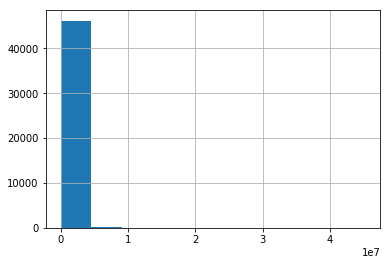

In [10]:
df['ConvertedCompYearly'].hist();

Filter some outliers.

In [11]:
df = df[
    (df['ConvertedCompYearly'] > df['ConvertedCompYearly'].quantile(.05)) &
    (df['ConvertedCompYearly'] < df['ConvertedCompYearly'].quantile(.95))
]

Checkout the distribution again. Now it should be fine.

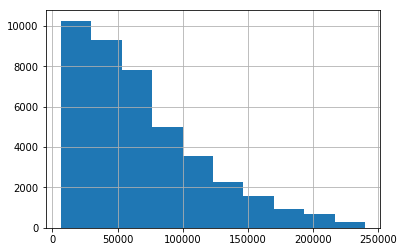

In [12]:
df['ConvertedCompYearly'].hist();

Generate at most $3$ features for text data

In [13]:
from collections import Counter

def generate_features_from_multiple_choices(col, k=3):
    """
    k is a maximal number of features to be generated
    """
    cnt = Counter()
    for el in df[col]:
        for feature in str(el).split(';'):
            cnt[feature] += 1
    del cnt['nan']
    
    for feature in [el[0] for el in cnt.most_common(k)]:
        df[f'{col}_{feature}'] = df[col].apply(lambda text: feature in str(text))
    df.drop(col, axis=1, inplace=True)

        
for col in ['LearnCode',
            'DevType',
            'LanguageHaveWorkedWith',
            'DatabaseHaveWorkedWith',
            'PlatformHaveWorkedWith',
            'WebframeHaveWorkedWith',
            'MiscTechHaveWorkedWith',
            'ToolsTechHaveWorkedWith',
            'NEWCollabToolsHaveWorkedWith',
            'NEWStuck',
            'NEWSOSites'
           ]:
    generate_features_from_multiple_choices(col)

Finally, have a look at what we got!

In [14]:
df.shape

(41636, 54)

In [15]:
df.head(2).T

9   \
MainBranch                                                           I am a developer by profession   
Employment                                                                       Employed full-time   
Country                                                                                       Other   
EdLevel                                             Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
Age1stCode                                                                            11 - 17 years   
YearsCode                                                                                         7   
YearsCodePro                                                                                      4   
OrgSize                                                                                       Other   
Currency                                                                                      Other   
OpSys                                                                                   Linux-based   
SOVisitFreq                                                                  Multiple times per day   
SOAccount                                                                                       Yes   
SOPartFreq                                                                    Daily or almost daily   
SOComm                                                                                Yes, somewhat   
NEWOtherComms                                                                                    No   
Age                                                                                 25-34 years old   
Gender                                                                                          Man   
Ethnicity                                                              White or of European descent   
SurveyLength                                                                  Appropriate in length   
SurveyEase                                                               Neither easy nor difficult   
ConvertedCompYearly                                                                           51552   
LearnCode_School                                                                               True   
LearnCode_Other online resources (ex: videos, b...                                            False   
LearnCode_Books / Physical media                                                              False   
DevType_Developer, full-stack                                                                 False   
DevType_Developer, back-end                                                                   False   
DevType_Developer, front-end                                                                  False   
LanguageHaveWorkedWith_JavaScript                                                             False   
LanguageHaveWorkedWith_HTML/CSS                                                               False   
LanguageHaveWorkedWith_SQL                                                                    False   
DatabaseHaveWorkedWith_PostgreSQL                                                              True   
DatabaseHaveWorkedWith_MySQL                                                                  False   
DatabaseHaveWorkedWith_Microsoft SQL Server                                                   False   
PlatformHaveWorkedWith_AWS                                                                    False   
PlatformHaveWorkedWith_Microsoft Azure                                                        False   
PlatformHaveWorkedWith_Google Cloud Platform                                                  False   
WebframeHaveWorkedWith_React.js                                                               False   
WebframeHaveWorkedWith_jQuery                                                                 False   
WebframeHaveWorkedWith_Angular                                                  

Let's do pandas-profiling again and see the result. It might take a bit longer since previous run. Of course, some of the generated features will be highly correlated.

In [16]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
df['Age'].unique()

array(['25-34 years old', '45-54 years old', '35-44 years old',
       '18-24 years old', '55-64 years old', '65 years or older', nan,
       'Under 18 years old', 'Prefer not to say'], dtype=object)

In [17]:
df['Age1stCode'].unique()

array(['11 - 17 years', '5 - 10 years', '25 - 34 years', '18 - 24 years',
       '35 - 44 years', 'Other'], dtype=object)

Drop rows with Age in [nan, 'Under 18 years old', 'Prefer not to say', '65 years or older'] and Age1stCode with value 'Other' and replace categorical values to average numeric for Age and Age1stCode

In [18]:
df = df[(df['Age'].notna()) & (df['Age'] != 'Under 18 years old') &
   (df['Age'] != 'Prefer not to say') & (df['Age'] != '65 years or older') & (df['Age1stCode'] != 'Other')]

look_up_age = {'25-34 years old': 29.5, '45-54 years old': 29.5, '35-44 years old': 39.5,
       '18-24 years old': 21, '55-64 years old': 59.5}
look_up_age_1st_code = {'11 - 17 years': 14, '5 - 10 years': 7.5, '25 - 34 years': 29.5, '18 - 24 years': 21,
       '35 - 44 years': 39.5}
age = df['Age'].apply(lambda v: look_up_age[v])
age_1st_code = df['Age1stCode'].apply(lambda v: look_up_age_1st_code[v])
df = df.drop(columns=['Age', 'Age1stCode'])
df['Age'] = age
df['Age1stCode'] = age_1st_code
df.T

9      \
MainBranch                                                           I am a developer by profession   
Employment                                                                       Employed full-time   
Country                                                                                       Other   
EdLevel                                             Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
YearsCode                                                                                         7   
YearsCodePro                                                                                      4   
OrgSize                                                                                       Other   
Currency                                                                                      Other   
OpSys                                                                                   Linux-based   
SOVisitFreq                                                                  Multiple times per day   
SOAccount                                                                                       Yes   
SOPartFreq                                                                    Daily or almost daily   
SOComm                                                                                Yes, somewhat   
NEWOtherComms                                                                                    No   
Gender                                                                                          Man   
Ethnicity                                                              White or of European descent   
SurveyLength                                                                  Appropriate in length   
SurveyEase                                                               Neither easy nor difficult   
ConvertedCompYearly                                                                           51552   
LearnCode_School                                                                               True   
LearnCode_Other online resources (ex: videos, b...                                            False   
LearnCode_Books / Physical media                                                              False   
DevType_Developer, full-stack                                                                 False   
DevType_Developer, back-end                                                                   False   
DevType_Developer, front-end                                                                  False   
LanguageHaveWorkedWith_JavaScript                                                             False   
LanguageHaveWorkedWith_HTML/CSS                                                               False   
LanguageHaveWorkedWith_SQL                                                                    False   
DatabaseHaveWorkedWith_PostgreSQL                                                              True   
DatabaseHaveWorkedWith_MySQL                                                                  False   
DatabaseHaveWorkedWith_Microsoft SQL Server                                                   False   
PlatformHaveWorkedWith_AWS                                                                    False   
PlatformHaveWorkedWith_Microsoft Azure                                                        False   
PlatformHaveWorkedWith_Google Cloud Platform                                                  False   
WebframeHaveWorkedWith_React.js                                                               False   
WebframeHaveWorkedWith_jQuery                                                                 False   
WebframeHaveWorkedWith_Angular                                                                False   
MiscTechHaveWorkedWith_.NET Framework                                                         False   
MiscTechHaveWorkedWith_.NET Core / .NET 5                                    

If your algorithm doesn't need OHE

In [20]:
X = df.drop('ConvertedCompYearly', axis=1)
y = df['ConvertedCompYearly']

If you need OHE

In [19]:
def ohe(df: pd.DataFrame):
    X = df.drop('ConvertedCompYearly', axis=1)
    y = df['ConvertedCompYearly']
    
    cat_cols = X.select_dtypes(include=['object']).columns
    for col in  cat_cols:
        X = pd.concat([X.drop(col, axis=1),
                       pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)],
                       axis=1)
    
    return X, y
    
X, y = ohe(df)

Of course, you may need additional preprocessing (like normalizing) suitable for your algorithm. But these $X$ and $y$ above provide a good starting point.

# PCA

Let's visualize the data. For this we will use PSA and take 2 components.

In [21]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [24]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X)

Let's split the target into five classes for best visualize the data

In [22]:
y_cat = np.array(y.copy())
y_cat[np.where(y_cat < 50000)] = 0
y_cat[np.where((50000 <= y_cat)&(y_cat < 100000))] = 1
y_cat[np.where((100000 <= y_cat)&(y_cat < 150000))] = 2
y_cat[np.where((150000 <= y_cat)&(y_cat < 200000))] = 3
y_cat[np.where(y_cat >= 200000)] = 4

In [26]:
y_cat = list(map(int, y_cat))

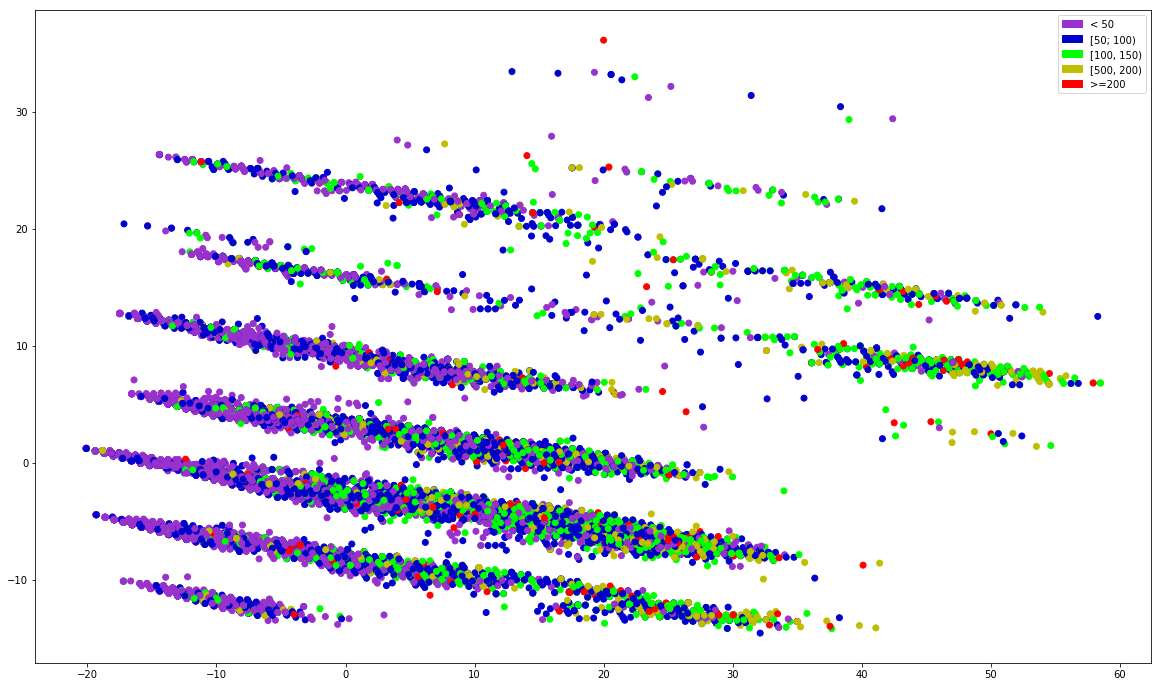

In [27]:
plt.figure(figsize=(20,12))
colormap = np.array(['darkorchid', 'mediumblue', 'lime', 'y', 'r'])
plt.scatter(data_pca.T[0], data_pca.T[1], c=colormap[y_cat]);
pop_a = mpatches.Patch(color='darkorchid', label='< 50')
pop_b = mpatches.Patch(color='mediumblue', label='[50; 100)')
pop_c = mpatches.Patch(color='lime', label='[100, 150)')
pop_d = mpatches.Patch(color='y', label='[500, 200)')
pop_e = mpatches.Patch(color='r', label='>=200')
plt.legend(handles=[pop_a,pop_b, pop_c, pop_d, pop_e]);

# Linear models

In [28]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBClassifier, XGBRegressor

In [35]:
def cross_validation_for_linear_model(data, target, clf):
    kf = KFold(n_splits=6, random_state=42, shuffle=False)
    error = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]
        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_scaler = scaler_x.transform(X_train)
#       #---------  y scale----------
#         scaler_y = StandardScaler()
#         scaler_y.fit(y_train)
#         y_train_scaler = scaler_y.transform(y_train)
#         cls.fit(X_train_scaler, y_train_scaler)
#         y_pred = cls.predict(scaler_x.transform(X_test))
#         error.append(mean_squared_error(scaler_y.transform(y_test), scaler_y.transform(y_pred)))
        
        cls.fit(X_train_scaler, y_train)
        y_pred = cls.predict(scaler_x.transform(X_test))
        error.append(mean_absolute_error(y_test, y_pred))
    print(cls, 'MAE error = ', np.mean(error))
    print()

In [36]:
clfs = [LinearRegression(), Ridge(alpha=10), Ridge(alpha=0.001), Lasso(alpha=10), Lasso(alpha=0.01)]

In [37]:
for cls in clfs:
    cross_validation_for_linear_model(np.array(X), np.array(y).reshape(-1, 1), cls)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) MAE error =  22840.64897277458

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001) MAE error =  22840.47244188563

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) MAE error =  22840.648917148585

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False) MAE error =  22839.871888936224



/home/tgorlenko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16185750325662.945, tolerance: 7629560229.501022
  positive)
/home/tgorlenko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16633122242576.32, tolerance: 7930523730.671571
  positive)
/home/tgorlenko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16400691955301.742, tolerance: 7708169927.288763
  positive)
/home/tgorlenko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to in

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) MAE error =  22840.499354757903



/home/tgorlenko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16558811884792.822, tolerance: 7780839689.782275
  positive)


In [38]:
clfs_boost = [XGBRegressor(), 
              XGBRegressor(n_estimators=500, learning_rate=0.1, n_jobs=-1),
             XGBRegressor(n_estimators=500, max_depth=4, learning_rate=0.1, n_jobs=-1)]

In [40]:
for cls in clfs_boost:
    cross_validation_for_linear_model(np.array(X), np.array(y).reshape(-1, 1), cls)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1) MAE error =  22148.21686915355

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1) MAE error =  21498.54994903697

XGBRegressor(base_score=0.5, booster=

In [248]:
clfs = [XGBRegressor(n_estimators=500, learning_rate=0.01, n_jobs=-1, max_depth=4, reg_alpha=0.1)]

In [249]:
for cls in clfs:
    cross_validation_for_linear_model(np.array(X), np.array(y).reshape(-1, 1), cls)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.01, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1) 22359.354620204394
